In [1]:
import os ##冰激淋+擔擔麵+蜂蜜檸檬適用

os.environ["CUDA_VISIBLE_DEVICES"] = "1" #使用第0張顯卡 ##冰激淋+擔擔麵+蜂蜜檸檬適用 0or1

In [2]:
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.9
set_session(tf.Session(config=config))

/opt/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
import keras
from keras import regularizers
from keras import backend as K
from keras.layers import Input, LSTM, Dense, Dropout, Flatten, Convolution1D, MaxPooling1D, Activation, BatchNormalization,\
Lambda, Concatenate, Add, Conv2D, Conv1D,TimeDistributed,MaxPooling2D
from keras.optimizers import Adam
from keras.models import load_model
from keras.callbacks import EarlyStopping
from keras.layers.advanced_activations import PReLU
from keras.models import Model
from keras.layers import Embedding
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import plot_model
from sklearn.preprocessing import MinMaxScaler
from itertools import combinations
from itertools import permutations
import matplotlib.pyplot as plt
import psutil
import os
import numpy as np
import pandas as pd
import datetime
import warnings
import pickle
import csv
import random
from keras.models import Sequential
from keras import backend as K

In [4]:
"""
基本設定
"""
#n=148335 #用2016 1~3月的資料 288x(31+29+31+30+31+30+...)=52416 210528-1(all) 差值在減一  
l=36 #區間為12小時
currency = ["BTC","DASH","ETH","JPY","EUR","AUD"]
#SEK:瑞典克朗  CHF:瑞士法郎 CAD:加拿大幣 GBP:英鎊 
#currency = ["BTC","DASH","ETH","LTC","JBY","GBP","EUR","AUD","US"]
currencynum = len(currency)
month = [0,31,60,91,121,152,182,213,244,274,305,335,366,397,425,456,486,517,547,578,609,639,670,700,731] #2016是閏年 366天
daynum = [0,5802,11745,18351,24380,30579,36861,42795,49201,55342,61230,67400,73732,79984,85726,92343,98127,104692,111028,117076,123700,129807,136083,142401,148335]
question = ["trand","volatility"]
# 貨幣組合，1 : P, 0 : C
M=0
head = 9
tail = 21
epochs = 70
batch_size = 4096
pl=4
kn=5
all_cur_pair = list(combinations(currency,2))# (Cn取2) 問題沒有先後順序時使用
if(M==0):
    all_cur_pair_P = list(combinations(currency,2))# (Cn取2) 問題沒有先後順序時使用
elif(M==1):
    all_cur_pair_P = list(permutations(currency,2))# (Pn取2) 問題有先後順序時使用  
all_question= list(permutations(question,1))
np.set_printoptions(suppress=True)#不要用科學符號輸出
lastepoch_train_acc = []
lastepoch_test_acc = []
lastepoch_train_loss = []
lastepoch_test_loss = []
total_test_vol = []
total_test_trend = []
train_length=3 
test_length=1 

In [5]:
"""""""""
str, onehotcode, company code轉換
"""""""""
currencylist = {}
questionlist = {}
for i in range(len(currency)):
    currencylist[i] = currency[i]

for i in range(len(question)):
    questionlist[i] = question[i]

def str_to_currency(cur):
    return {v: k for k, v in currencylist.items()}[cur]

def str_to_question(q):
    return {v: k for k, v in questionlist.items()}[q]


def one_hot_currency(currencylist):
    d = {}
    temp = np.eye((len(currencylist)))
    for i in range(len(currencylist)):
        d[i] = temp[i]
    return d

def one_hot_question(questionlist):
    d = {}
    temp = np.eye((len(questionlist)))
    for i in range(len(questionlist)):
        d[i] = temp[i]
    return d

onehotcurrency = one_hot_currency(currencylist)
onehotquestion = one_hot_question(questionlist)

In [6]:
"""
Q&A
"""
vol='volatility'
def set_question(com1, com2, condition,typeq):
    # set condition
    def rise_of_fall():
        #目前問題設定只有三種設定：前者大(big)-0、後者大(small)-1、一樣(s)-2
        tmp = np.eye((2))
        d = {0:tmp[0],1:tmp[1]}
        return d
    # 拼接問題
    return np.concatenate((onehotquestion[str_to_question(typeq)],onehotcurrency[str_to_currency(com1)], onehotcurrency[str_to_currency(com2)], rise_of_fall()[condition]))

qtype = ['big','small']
HVqtype = ['big','small']

"""比漲幅程度類問題"""
def set_question_and_answer_pair(data, data2, n, all_cur_pair_P): #比較波動率大小的問題
    q_pair = {}
    a_pair = {}
    outcome=np.zeros((currencynum,1))
    for c in range(currencynum):
        data2[c]=data2[c]-data2[c][0]
    #data_sum=np.sum(data,axis=1)
    data2_sum=np.sum(data2,axis=1)
    outcome[0]=(data2_sum[0])
    outcome[1]=(data2_sum[1])
    outcome[2]=(data2_sum[2])
    outcome[3]=(data2_sum[3])
    outcome[4]=(data2_sum[4])
    outcome[5]=(data2_sum[5])
    # question_type (目前有3種小問題：前者大、後者大或者一樣)
    for i in range(2):
        tmp_q = []
        tmp_a = []
            
        #先塞question pairs
        for j in range(len(all_cur_pair_P)):
            tmp_q.append(set_question(all_cur_pair_P[j][0], all_cur_pair_P[j][1], i, all_question[0][0]))
        q_pair[i] = tmp_q
        
        #再塞answer pairs
        if(i == 0): #同漲
            for j in range(len(all_cur_pair_P)):
                if(outcome[str_to_currency(all_cur_pair_P[j][0])] >= outcome[str_to_currency(all_cur_pair_P[j][1])]):
                    tmp_a.append(1)
                else:
                    tmp_a.append(0)
        elif(i == 1):
            for j in range(len(all_cur_pair_P)):
                if(outcome[str_to_currency(all_cur_pair_P[j][0])] < outcome[str_to_currency(all_cur_pair_P[j][1])]):
                    tmp_a.append(1)
                else:
                    tmp_a.append(0)
                    
        a_pair[i] = tmp_a
        
    return (data, q_pair, a_pair)


"""History Volatility類問題"""
def set_HVquestion_and_HVanswer_pair(data, data2,all_cur_pair_P): #比較波動率大小的問題
    q_HVpair = {}
    a_HVpair = {}
    outcome=np.zeros((currencynum,1))
    for c in range(currencynum):
        data2[c]=data2[c]-data2[c][0]
    data2_std=np.std(data2,axis=1) 
    outcome[0]=data2_std[0]
    outcome[1]=data2_std[1]
    outcome[2]=data2_std[2]
    outcome[3]=data2_std[3]
    outcome[4]=data2_std[4]
    outcome[5]=data2_std[5]     
    # question_type (目前有3種小問題：前者大、後者大或者一樣)
    for i in range(2):
        tmp_q = []
        tmp_a = []
        
        #先塞question pairs
        for j in range(len(all_cur_pair_P)):
            tmp_q.append(set_question(all_cur_pair_P[j][0], all_cur_pair_P[j][1], i,all_question[1][0]))
        q_HVpair[i] = tmp_q
        
        #再塞answer pairs
        if(i == 0): #前者大
            for j in range(len(all_cur_pair_P)):
                if(outcome[str_to_currency(all_cur_pair_P[j][0])] >= outcome[str_to_currency(all_cur_pair_P[j][1])]):
                    tmp_a.append(1)
                else:
                    tmp_a.append(0)
        elif(i == 1):
            for j in range(len(all_cur_pair_P)):
                if(outcome[str_to_currency(all_cur_pair_P[j][0])] < outcome[str_to_currency(all_cur_pair_P[j][1])]):
                    tmp_a.append(1)
                else:
                    tmp_a.append(0)
                    
        a_HVpair[i] = tmp_a
        
    return (data, q_HVpair, a_HVpair)

In [7]:
"""
此處開始寫rolling
"""

def fit_show(traindata,m1,m2,m3):
    
    vqa_pair = []
    for i in range(0,m3-m1-l-l,1):
        vqa_pair.append(set_question_and_answer_pair(Train_data[i],Train_data[i+l],i+l-1,all_cur_pair_P))  
        vqa_pair.append(set_HVquestion_and_HVanswer_pair(Train_data[i],Train_data[i+l],all_cur_pair_P))
        #這裡交叉塞資料才不會不小心預測未來
            
    v_tmp, q_tmp, a_tmp = [],[],[]
    for i in range(len(vqa_pair)):
        v_tmp.append(vqa_pair[i][0])
        q_tmp.append(vqa_pair[i][1])
        a_tmp.append(vqa_pair[i][2])
    v = np.array(v_tmp)
    
    # 下面這行會導致memory error
    import tracemalloc
    # Start tracing
    tracemalloc.start()
    v = np.repeat(v, len(all_cur_pair_P)*len(qtype), axis = 0)
    #這裡要注意問題的分類數量(2種:波動和漲跌)已經在前面vqa_pair變成兩倍過了
    #這裡只要考慮貨幣組合數量(P的N取2)和問的問題數量(高低同)
    snap = tracemalloc.take_snapshot()
    # Evaluate result
    stats = snap.statistics('lineno')
    for stat in stats[:1]:
        print(stat)
    
    q, a = [],[]
    for i in range(len(q_tmp)):
        for value in q_tmp[i].values():
            q.append(value)
    q = np.vstack(q)
    q = np.vstack(q)
    
    for i in range(len(a_tmp)):
        for value in a_tmp[i].values():
            a.append(value)
    a = np.vstack(a)
    a = a.reshape(a.shape[0]*a.shape[1])
    v=np.swapaxes(v,1,2)
    print(v.shape)
    v = v.reshape(len(v),currencynum,l,1)
    print(v.shape)
    print("[Training model......]")
    
    #Train_v=v[:]
    
    Train_v=v[:((m2-m1)-l*2)*len(all_cur_pair_P)*len(qtype)*2]# -1-72+1=-72
    Train_q=q[:((m2-m1)-l*2)*len(all_cur_pair_P)*len(qtype)*2]
    Train_a=a[:((m2-m1)-l*2)*len(all_cur_pair_P)*len(qtype)*2]
    Test_v=v[((m2-m1))*len(all_cur_pair_P)*len(qtype)*2:]
    Test_q=q[((m2-m1))*len(all_cur_pair_P)*len(qtype)*2:]
    Test_a=a[((m2-m1))*len(all_cur_pair_P)*len(qtype)*2:]
    history = model.fit([Train_v, Train_q], Train_a,validation_data=([Test_v,Test_q],Test_a),batch_size=batch_size ,epochs = epochs,shuffle=False)
    pred = model.predict([Test_v, Test_q])
    count = 0
    print(pred)
    for i in range(pred.shape[0]):
        if pred[i] <= 0.5:
            pred[i] = 0
        else:
            pred[i] = 1
            
        if pred[i] == Test_a[i]:
            count+=1
    print(count,count/pred.shape[0])
    """
    分開兩種問題的test集
    """
    flag=0
    v_trend=[]
    q_trend=[]
    a_trend=[]
    v_vol=[]
    q_vol=[]
    a_vol=[]
    trend_count=0
    vol_count=0
    for ii in range(0,len(Test_q)):
        if(flag==0):
            #print(0)
            v_trend.append(Test_v[ii])
            q_trend.append(Test_q[ii])
            a_trend.append(Test_a[ii])
            trend_count=trend_count+1
            if(trend_count==90):
                trend_count=0
                flag=1
        elif(flag==1):
            #print(1)
            v_vol.append(Test_v[ii])
            q_vol.append(Test_q[ii])
            a_vol.append(Test_a[ii])
            vol_count=vol_count+1
            if(vol_count==90):
                vol_count=0
                flag=0
    
    """
    分開兩種問題的predict正確率
    """
    pred_trend = model.predict([v_trend, q_trend])
    count = 0
    for i in range(pred_trend.shape[0]):
        if pred_trend[i] <= 0.5:
            pred_trend[i] = 0
        else:
            pred_trend[i] = 1
            
        if pred_trend[i] == a_trend[i]:
            count+=1
    print("trend_test_acc:")
    print(count,count/pred_trend.shape[0])    
    total_test_trend.append(count/pred_trend.shape[0])

    pred_vol = model.predict([v_vol, q_vol])
    count = 0
    for i in range(pred_vol.shape[0]):
        if pred_vol[i] <= 0.5:
            pred_vol[i] = 0
        else:
            pred_vol[i] = 1
            
        if pred_vol[i] == a_vol[i]:
            count+=1
    print("vol_test_acc:")
    print(count,count/pred_vol.shape[0]) 
    total_test_vol.append(count/pred_vol.shape[0])
    
    print("Reverse section--------------------------------------------------------------------------")
    Test_q_reverse=Test_q
    temp=Test_q_reverse[:,2:8]
    Test_q_reverse[:,2:8]=Test_q_reverse[:,8:14]
    Test_q_reverse[:,8:14]=temp
    Test_a_reverse=-1*Test_a+1
    pred = model.predict([Test_v, Test_q_reverse])
    count = 0
    print(pred)
    for i in range(pred.shape[0]):
        if pred[i] <= 0.5:
            pred[i] = 0
        else:
            pred[i] = 1
            
        if pred[i] == Test_a_reverse[i]:
            count+=1
    print(count,count/pred.shape[0])

    """
    分開兩種問題的test集_reverse
    """
    flag=0
    v_trend=[]
    q_trend=[]
    a_trend=[]
    v_vol=[]
    q_vol=[]
    a_vol=[]
    trend_count=0
    vol_count=0
    cycle = ((currencynum*(currencynum-1))/2)*len(question)*len(qtype)
    for ii in range(0,len(Test_q)):
        if(flag==0):
            #print(0)
            v_trend.append(Test_v[ii])
            q_trend.append(Test_q[ii])
            a_trend.append(Test_a[ii])
            trend_count=trend_count+1
            if(trend_count==cycle):
                trend_count=0
                flag=1
        elif(flag==1):
            #print(1)
            v_vol.append(Test_v[ii])
            q_vol.append(Test_q[ii])
            a_vol.append(Test_a[ii])
            vol_count=vol_count+1
            if(vol_count==cycle):
                vol_count=0
                flag=0
    
    """
    分開兩種問題的predict正確率_reverse
    """
    pred_trend = model.predict([v_trend, q_trend])
    count = 0
    for i in range(pred_trend.shape[0]):
        if pred_trend[i] <= 0.5:
            pred_trend[i] = 0
        else:
            pred_trend[i] = 1
            
        if pred_trend[i] == a_trend[i]:
            count+=1
    print("trend_test_acc:")
    print(count,count/pred_trend.shape[0])    
    total_test_trend.append(count/pred_trend.shape[0])

    pred_vol = model.predict([v_vol, q_vol])
    count = 0
    for i in range(pred_vol.shape[0]):
        if pred_vol[i] <= 0.5:
            pred_vol[i] = 0
        else:
            pred_vol[i] = 1
            
        if pred_vol[i] == a_vol[i]:
            count+=1
    print("vol_test_acc:")
    print(count,count/pred_vol.shape[0]) 
    total_test_vol.append(count/pred_vol.shape[0])
    
    """
    benchmark1
    """
    benchacc=0
    for i in range(Test_a.shape[0]):
        benchacc=benchacc+Test_a[i]
    benchacc=benchacc/Test_a.shape[0]    
    if(benchacc<0.5):
        benchacc=1-benchacc
    print("猜答案多的那邊 benchacc1:")
    print(benchacc)

    """
    benchmark2
    """
    #第一個直接猜1
    benchacc=0
    for i in range(Test_a.shape[0]-1):
        if(Test_a[i]!=Test_a[i+1]):
            benchacc=benchacc+1
    benchacc=benchacc/Test_a.shape[0]    
    if(benchacc<0.5):
        benchacc=1-benchacc
    print("參考前一個答案 benchacc2:")
    print(benchacc)    
    """
    畫圖
    """
    benchfunction=np.ones(a.shape[0])
    benchfunction=benchfunction*benchacc
    plt.plot(history.history['loss'], label='train')
    lastepoch_train_loss.append(history.history['loss'][-1])
    plt.plot(history.history['val_loss'], label='test')
    lastepoch_test_loss.append(history.history['val_loss'][-1])
    print("loss:")
    print(history.history['loss'][-1])
    print("val_loss:")
    print(history.history['val_loss'][-1])
    plt.xlabel("epoch") 
    plt.ylabel("loss") 
    #plt.title("The Title") 
    plt.legend()
    plt.show()
    
        
def ConvolutionNetworks(fn,ks):
    def conv(model):
        for i in range(len(fn)):
            model = (Conv2D(filters=fn[i],kernel_size=ks[i],padding='valid',activation='relu'))(model)  
            model = (MaxPooling2D(pool_size=(1,pl)))(model)
            model = BatchNormalization()(model)
        return model
    return conv



def get_dense(n, MLP_unit):
    r = []
    for k in range(n):
        r.append(Dense(MLP_unit, activation='relu'))
    return r

def get_MLP(n, denses):
    def g(x):
        d = x
        for k in range(n):
            d = denses[k](d)
        return d
    return g

def dropout_dense(x,MLP_unit):
    y = Dense(MLP_unit)(x)
    y = Dropout(0.5)(y)
    y = Activation('relu')(y)
    return y


def build_tag(conv):
    d = K.int_shape(conv)[1]
    d2 = K.int_shape(conv)[2]
    tag = np.zeros((d,d2,d+1))
    for i in range(d):
        for j in range(d2):
            tag[i,j,d] = float(int(i%d))/(d-1)*2-1
            tag[i,j,i] = 1
    tag = K.variable(tag)
    tag = K.expand_dims(tag,axis=0)
    batch_size = K.shape(conv)[0]
    tag = K.tile(tag,[batch_size,1,1,1])
    print(K.int_shape(tag))
    return Input(tensor=tag)
    plt.show()    
def ConvolutionNetworks(fn,ks):
    def conv(model):
        for i in range(len(fn)):
            model = (Conv2D(filters=fn[i],kernel_size=ks[i],padding='valid',activation='relu'))(model)  
            model = (MaxPooling2D(pool_size=(1,pl)))(model)
            model = BatchNormalization()(model)
        return model
    return conv



def get_dense(n, MLP_unit):
    r = []
    for k in range(n):
        r.append(Dense(MLP_unit, activation='relu'))
    return r

def get_MLP(n, denses):
    def g(x):
        d = x
        for k in range(n):
            d = denses[k](d)
        return d
    return g

def dropout_dense(x,MLP_unit):
    y = Dense(MLP_unit)(x)
    y = Dropout(0.5)(y)
    y = Activation('relu')(y)
    return y


def build_tag(conv):
    d = K.int_shape(conv)[1]
    d2 = K.int_shape(conv)[2]
    tag = np.zeros((d,d2,d+1))
    for i in range(d):
        for j in range(d2):
            tag[i,j,d] = float(int(i%d))/(d-1)*2-1
            tag[i,j,i] = 1
    tag = K.variable(tag)
    tag = K.expand_dims(tag,axis=0)
    batch_size = K.shape(conv)[0]
    tag = K.tile(tag,[batch_size,1,1,1])
    print(K.int_shape(tag))
    return Input(tensor=tag)

(148335, 1)
finish dataread
(None, 6, 1, 10)
(None, 6, 1, 7)
(None, 6, 1, 17)
g_MLP
drop_out
compile model success
12
/opt/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:52: size=2405 MiB, count=2, average=1202 MiB
(1459380, 36, 6)
(1459380, 6, 36, 1)
[Training model......]
Train on 1112340 samples, validate on 342720 samples
Epoch 1/40
1112340/1112340 [==============================] - 16s 14us/step - loss: 1.0803 - acc: 0.5029 - val_loss: 0.6863 - val_acc: 0.5569
Epoch 2/40
1112340/1112340 [==============================] - 10s 9us/step - loss: 0.7396 - acc: 0.5207 - val_loss: 0.6681 - val_acc: 0.6053
Epoch 3/40
1112340/1112340 [==============================] - 10s 9us/step - loss: 0.6845 - acc: 0.5581 - val_loss: 0.6264 - val_acc: 0.6215
Epoch 4/40
1112340/1112340 [==============================] - 10s 9us/step - loss: 0.6363 - acc: 0.6054 - val_loss: 0.5714 - val_acc: 0.6248
Epoch 5/40
1112340/1112340 [==============================] - 10s 9us/step - loss: 0.5851 

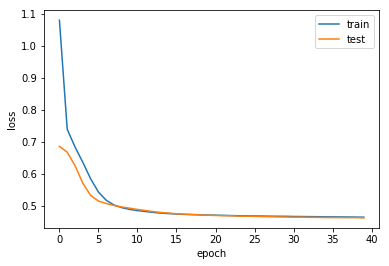

(148335, 1)
finish dataread
(None, 6, 1, 10)
(None, 6, 1, 7)
(None, 6, 1, 17)
g_MLP
drop_out
compile model success
13
/opt/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:52: size=2436 MiB, count=155, average=15.7 MiB
(1478160, 36, 6)
(1478160, 6, 36, 1)
[Training model......]
Train on 1084260 samples, validate on 389580 samples
Epoch 1/40
1084260/1084260 [==============================] - 15s 14us/step - loss: 1.0507 - acc: 0.5157 - val_loss: 0.6741 - val_acc: 0.5981
Epoch 2/40
1084260/1084260 [==============================] - 10s 9us/step - loss: 0.7131 - acc: 0.5522 - val_loss: 0.6637 - val_acc: 0.6163
Epoch 3/40
1084260/1084260 [==============================] - 10s 9us/step - loss: 0.6728 - acc: 0.5904 - val_loss: 0.6394 - val_acc: 0.6293
Epoch 4/40
1084260/1084260 [==============================] - 10s 9us/step - loss: 0.6405 - acc: 0.6236 - val_loss: 0.6032 - val_acc: 0.6302
Epoch 5/40
1084260/1084260 [==============================] - 10s 9us/step - loss: 0.603

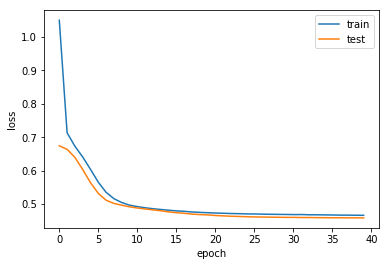

(148335, 1)
finish dataread
(None, 6, 1, 10)
(None, 6, 1, 7)
(None, 6, 1, 17)
g_MLP
drop_out
compile model success
14
/opt/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:52: size=2495 MiB, count=157, average=15.9 MiB
(1513800, 36, 6)
(1513800, 6, 36, 1)
[Training model......]
Train on 1133640 samples, validate on 375840 samples
Epoch 1/40
1133640/1133640 [==============================] - 17s 15us/step - loss: 1.4686 - acc: 0.5041 - val_loss: 0.6904 - val_acc: 0.5541
Epoch 2/40
1133640/1133640 [==============================] - 10s 9us/step - loss: 0.7893 - acc: 0.5172 - val_loss: 0.6732 - val_acc: 0.5984
Epoch 3/40
1133640/1133640 [==============================] - 10s 9us/step - loss: 0.7109 - acc: 0.5394 - val_loss: 0.6573 - val_acc: 0.6206
Epoch 4/40
1133640/1133640 [==============================] - 10s 9us/step - loss: 0.6775 - acc: 0.5759 - val_loss: 0.6310 - val_acc: 0.6355
Epoch 5/40
1133640/1133640 [==============================] - 10s 9us/step - loss: 0.646

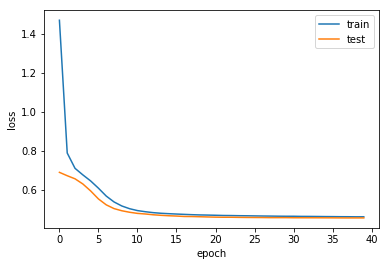

(148335, 1)
finish dataread
(None, 6, 1, 10)
(None, 6, 1, 7)
(None, 6, 1, 17)
g_MLP
drop_out
compile model success
15
/opt/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:52: size=2438 MiB, count=158, average=15.4 MiB
(1479660, 36, 6)
(1479660, 6, 36, 1)
[Training model......]
Train on 1116780 samples, validate on 358560 samples
Epoch 1/40
1116780/1116780 [==============================] - 17s 15us/step - loss: 1.3095 - acc: 0.5131 - val_loss: 0.6976 - val_acc: 0.5412
Epoch 2/40
1116780/1116780 [==============================] - 10s 9us/step - loss: 0.7487 - acc: 0.5365 - val_loss: 0.6744 - val_acc: 0.5991
Epoch 3/40
1116780/1116780 [==============================] - 10s 9us/step - loss: 0.6874 - acc: 0.5696 - val_loss: 0.6564 - val_acc: 0.6276
Epoch 4/40
1116780/1116780 [==============================] - 10s 9us/step - loss: 0.6650 - acc: 0.6002 - val_loss: 0.6391 - val_acc: 0.6295
Epoch 5/40
1116780/1116780 [==============================] - 10s 9us/step - loss: 0.641

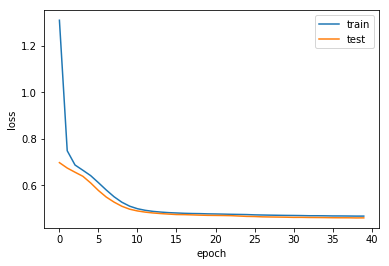

(148335, 1)
finish dataread
(None, 6, 1, 10)
(None, 6, 1, 7)
(None, 6, 1, 17)
g_MLP
drop_out
compile model success
16
/opt/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:52: size=2521 MiB, count=158, average=16.0 MiB
(1530060, 36, 6)
(1530060, 6, 36, 1)
[Training model......]
Train on 1132620 samples, validate on 393120 samples
Epoch 1/40
1132620/1132620 [==============================] - 17s 15us/step - loss: 0.9700 - acc: 0.5122 - val_loss: 0.6745 - val_acc: 0.6157
Epoch 2/40
1132620/1132620 [==============================] - 10s 9us/step - loss: 0.7238 - acc: 0.5420 - val_loss: 0.6558 - val_acc: 0.6327
Epoch 3/40
1132620/1132620 [==============================] - 10s 9us/step - loss: 0.6740 - acc: 0.5862 - val_loss: 0.6237 - val_acc: 0.6368
Epoch 4/40
1132620/1132620 [==============================] - 10s 9us/step - loss: 0.6318 - acc: 0.6255 - val_loss: 0.5771 - val_acc: 0.6469
Epoch 5/40
1132620/1132620 [==============================] - 10s 9us/step - loss: 0.586

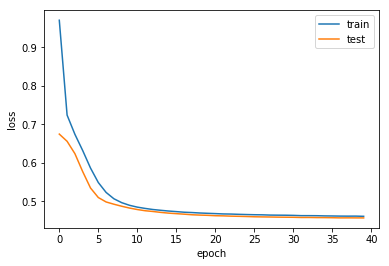

In [8]:
for z in range(head,tail,1):
    """
     V
    """
    n=daynum[tail]-daynum[head]
    df = pd.read_csv('data/JPY_data_ver2.0.csv',header=None)  # 讀取訓練數據
    print(df.shape)  
    jpy5months = np.zeros(n)
    dt=0
    for i in range(daynum[head],daynum[tail],1):
        jpy5months[dt] = df[0][i]  
        dt=dt+1
    df = pd.read_csv('data/EUR_data_ver2.0.csv',header=None)  # 讀取訓練數據
    eur5months = np.zeros(n)
    dt=0
    for i in range(daynum[head],daynum[tail],1):
        eur5months[dt] = df[0][i]  
        dt=dt+1
    df = pd.read_csv('data/AUD_data_ver2.0.csv',header=None)  # 讀取訓練數據
    aud5months = np.zeros(n)
    dt=0
    for i in range(daynum[head],daynum[tail],1):
        aud5months[dt] = df[0][i]  
        dt=dt+1
    df = pd.read_csv('data/btc_data_ver2.0.csv',header=None)  # 讀取訓練數據
    btc5months = np.zeros(n)
    dt=0
    for i in range(daynum[head],daynum[tail],1):
        btc5months[dt] = df[0][i]  
        dt=dt+1
    df = pd.read_csv('data/eth_data_ver2.0.csv',header=None)  # 讀取訓練數據
    eth5months = np.zeros(n)
    dt=0
    for i in range(daynum[head],daynum[tail],1):
        eth5months[dt] = df[0][i]  
        dt=dt+1
    df = pd.read_csv('data/DASH_data_ver2.0.csv',header=None)  # 讀取訓練數據
    dash5months = np.zeros(n)
    dt=0
    for i in range(daynum[head],daynum[tail],1):
        dash5months[dt] = df[0][i]  
        dt=dt+1
    print('finish dataread')
    Train_data=np.zeros(((n-l+1,len(currency),l)))
    for p in range(n-l+1):
        Train_data[p,0,:]=btc5months[p:p+l]
        Train_data[p,1,:]=dash5months[p:p+l]
        Train_data[p,2,:]=eth5months[p:p+l]
        Train_data[p,3,:]=jpy5months[p:p+l]
        Train_data[p,4,:]=eur5months[p:p+l]
        Train_data[p,5,:]=aud5months[p:p+l]
    MLP_unit=64
    visual_scene = Input((currencynum,l,1))
    visual_conv = ConvolutionNetworks([20,10],[(1,kn),(1,kn)])(visual_scene)
    print(K.int_shape(visual_conv))
    tag = build_tag(visual_conv)
    visual_conv = Concatenate()([tag, visual_conv])
    print(K.int_shape(visual_conv))
    
    shapes = visual_conv.shape
    w = shapes[1]
    f = shapes[2]
    features= []
    #features = np.zeros(0)
    for k1 in range(w):
        for k2 in range(f):
            def get_feature(t):
                return t[:, k1, k2, :]
            #get_feature_layer = Lambda(get_feature)
            features.append(Lambda(get_feature)(visual_conv))
    
      
    input2 = Input((16,))
    onehot_encode_question = input2
    relations = []
    concat = Concatenate()
    for feature1 in features:
        for feature2 in features:
            relations.append(concat([feature1, feature2, onehot_encode_question]))    
    
     
    g_MLP = get_MLP(4, get_dense(4,MLP_unit))
    
    print("g_MLP")
    mid_relations = []
    for r in relations:
        mid_relations.append(g_MLP(r))
    
    combined_relation = Add()(mid_relations)
    
    #f_MLP
    rn = dropout_dense(combined_relation,MLP_unit)
    rn = dropout_dense(rn,MLP_unit)
    print('drop_out')
    
    pred = Dense(1, activation = 'sigmoid')(rn)
    
    
    #model = Model(inputs=[visual_scene])
    model = Model(inputs=[visual_scene, input2, tag], outputs = pred)
    optimizer = Adam(lr = 3e-5)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    print('compile model success')    

    #model.summary()
    print(z)
    fit_show(Train_data,daynum[z],daynum[z+3],daynum[z+4])
    

In [9]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           (None, 6, 36, 1)     0                                            
__________________________________________________________________________________________________
conv2d_9 (Conv2D)               (None, 6, 32, 20)    120         input_13[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_9 (MaxPooling2D)  (None, 6, 8, 20)     0           conv2d_9[0][0]                   
__________________________________________________________________________________________________
batch_normalization_9 (BatchNor (None, 6, 8, 20)     80          max_pooling2d_9[0][0]            
__________________________________________________________________________________________________
conv2d_10 

In [10]:
K.clear_session()

In [8]:
"""
此處開始寫rolling
"""

def fit_show(traindata,m1,m2,m3):
    
    vqa_pair = []
    for i in range(0,m3-m1-l-l,1):
        vqa_pair.append(set_question_and_answer_pair(Train_data[i],Train_data[i+l],i+l-1,all_cur_pair_P))  
        vqa_pair.append(set_HVquestion_and_HVanswer_pair(Train_data[i],Train_data[i+l],all_cur_pair_P))
        #這裡交叉塞資料才不會不小心預測未來
            
    v_tmp, q_tmp, a_tmp = [],[],[]
    for i in range(len(vqa_pair)):
        v_tmp.append(vqa_pair[i][0])
        q_tmp.append(vqa_pair[i][1])
        a_tmp.append(vqa_pair[i][2])
    v = np.array(v_tmp)
    
    # 下面這行會導致memory error
    import tracemalloc
    # Start tracing
    tracemalloc.start()
    v = np.repeat(v, len(all_cur_pair_P)*len(qtype), axis = 0)
    #這裡要注意問題的分類數量(2種:波動和漲跌)已經在前面vqa_pair變成兩倍過了
    #這裡只要考慮貨幣組合數量(P的N取2)和問的問題數量(高低同)
    snap = tracemalloc.take_snapshot()
    # Evaluate result
    stats = snap.statistics('lineno')
    for stat in stats[:1]:
        print(stat)
    
    q, a = [],[]
    for i in range(len(q_tmp)):
        for value in q_tmp[i].values():
            q.append(value)
    q = np.vstack(q)
    q = np.vstack(q)
    
    for i in range(len(a_tmp)):
        for value in a_tmp[i].values():
            a.append(value)
    a = np.vstack(a)
    a = a.reshape(a.shape[0]*a.shape[1])
    v=np.swapaxes(v,1,2)
    print(v.shape)
    v = v.reshape(len(v),currencynum,l,1)
    print(v.shape)
    print("[Training model......]")
    
    #Train_v=v[:]
    
    Train_v=v[:((m2-m1)-l*2)*len(all_cur_pair_P)*len(qtype)*2]# -1-72+1=-72
    Train_q=q[:((m2-m1)-l*2)*len(all_cur_pair_P)*len(qtype)*2]
    Train_a=a[:((m2-m1)-l*2)*len(all_cur_pair_P)*len(qtype)*2]
    Test_v=v[((m2-m1))*len(all_cur_pair_P)*len(qtype)*2:]
    Test_q=q[((m2-m1))*len(all_cur_pair_P)*len(qtype)*2:]
    Test_a=a[((m2-m1))*len(all_cur_pair_P)*len(qtype)*2:]
    history = model.fit([Train_v, Train_q], Train_a,validation_data=([Test_v,Test_q],Test_a),batch_size=batch_size ,epochs = epochs,shuffle=False)
    pred = model.predict([Test_v, Test_q])
    count = 0
    print(pred)
    
    """
    benchmark1
    """
    benchacc=0
    for i in range(Test_a.shape[0]):
        benchacc=benchacc+Test_a[i]
    benchacc=benchacc/Test_a.shape[0]    
    if(benchacc<0.5):
        benchacc=1-benchacc
    print("猜答案多的那邊 benchacc1:")
    print(benchacc)

    """
    benchmark2
    """
    #第一個直接猜1
    benchacc=0
    for i in range(Test_a.shape[0]-1):
        if(Test_a[i]!=Test_a[i+1]):
            benchacc=benchacc+1
    benchacc=benchacc/Test_a.shape[0]    
    if(benchacc<0.5):
        benchacc=1-benchacc
    print("參考前一個答案 benchacc2:")
    print(benchacc)    

        
def ConvolutionNetworks(fn,ks):
    def conv(model):
        for i in range(len(fn)):
            model = (Conv2D(filters=fn[i],kernel_size=ks[i],padding='valid',activation='relu'))(model)  
            model = (MaxPooling2D(pool_size=(1,pl)))(model)
            model = BatchNormalization()(model)
        return model
    return conv



def get_dense(n, MLP_unit):
    r = []
    for k in range(n):
        r.append(Dense(MLP_unit, activation='relu'))
    return r

def get_MLP(n, denses):
    def g(x):
        d = x
        for k in range(n):
            d = denses[k](d)
        return d
    return g

def dropout_dense(x,MLP_unit):
    y = Dense(MLP_unit)(x)
    y = Dropout(0.5)(y)
    y = Activation('relu')(y)
    return y


def build_tag(conv):
    d = K.int_shape(conv)[1]
    d2 = K.int_shape(conv)[2]
    tag = np.zeros((d,d2,d+1))
    for i in range(d):
        for j in range(d2):
            tag[i,j,d] = float(int(i%d))/(d-1)*2-1
            tag[i,j,i] = 1
    tag = K.variable(tag)
    tag = K.expand_dims(tag,axis=0)
    batch_size = K.shape(conv)[0]
    tag = K.tile(tag,[batch_size,1,1,1])
    print(K.int_shape(tag))
    return Input(tensor=tag)
    plt.show()    
def ConvolutionNetworks(fn,ks):
    def conv(model):
        for i in range(len(fn)):
            model = (Conv2D(filters=fn[i],kernel_size=ks[i],padding='valid',activation='relu'))(model)  
            model = (MaxPooling2D(pool_size=(1,pl)))(model)
            model = BatchNormalization()(model)
        return model
    return conv



def get_dense(n, MLP_unit):
    r = []
    for k in range(n):
        r.append(Dense(MLP_unit, activation='relu'))
    return r

def get_MLP(n, denses):
    def g(x):
        d = x
        for k in range(n):
            d = denses[k](d)
        return d
    return g

def dropout_dense(x,MLP_unit):
    y = Dense(MLP_unit)(x)
    y = Dropout(0.5)(y)
    y = Activation('relu')(y)
    return y


def build_tag(conv):
    d = K.int_shape(conv)[1]
    d2 = K.int_shape(conv)[2]
    tag = np.zeros((d,d2,d+1))
    for i in range(d):
        for j in range(d2):
            tag[i,j,d] = float(int(i%d))/(d-1)*2-1
            tag[i,j,i] = 1
    tag = K.variable(tag)
    tag = K.expand_dims(tag,axis=0)
    batch_size = K.shape(conv)[0]
    tag = K.tile(tag,[batch_size,1,1,1])
    print(K.int_shape(tag))
    return Input(tensor=tag)

In [9]:
for z in range(head,tail,1):
    """
     V
    """
    n=daynum[tail]-daynum[head]
    df = pd.read_csv('data/JPY_data_ver2.0.csv',header=None)  # 讀取訓練數據
    print(df.shape)  
    jpy5months = np.zeros(n)
    dt=0
    for i in range(daynum[head],daynum[tail],1):
        jpy5months[dt] = df[0][i]  
        dt=dt+1
    df = pd.read_csv('data/EUR_data_ver2.0.csv',header=None)  # 讀取訓練數據
    eur5months = np.zeros(n)
    dt=0
    for i in range(daynum[head],daynum[tail],1):
        eur5months[dt] = df[0][i]  
        dt=dt+1
    df = pd.read_csv('data/AUD_data_ver2.0.csv',header=None)  # 讀取訓練數據
    aud5months = np.zeros(n)
    dt=0
    for i in range(daynum[head],daynum[tail],1):
        aud5months[dt] = df[0][i]  
        dt=dt+1
    df = pd.read_csv('data/btc_data_ver2.0.csv',header=None)  # 讀取訓練數據
    btc5months = np.zeros(n)
    dt=0
    for i in range(daynum[head],daynum[tail],1):
        btc5months[dt] = df[0][i]  
        dt=dt+1
    df = pd.read_csv('data/eth_data_ver2.0.csv',header=None)  # 讀取訓練數據
    eth5months = np.zeros(n)
    dt=0
    for i in range(daynum[head],daynum[tail],1):
        eth5months[dt] = df[0][i]  
        dt=dt+1
    df = pd.read_csv('data/DASH_data_ver2.0.csv',header=None)  # 讀取訓練數據
    dash5months = np.zeros(n)
    dt=0
    for i in range(daynum[head],daynum[tail],1):
        dash5months[dt] = df[0][i]  
        dt=dt+1
    print('finish dataread')
    Train_data=np.zeros(((n-l+1,len(currency),l)))
    for p in range(n-l+1):
        Train_data[p,0,:]=btc5months[p:p+l]
        Train_data[p,1,:]=dash5months[p:p+l]
        Train_data[p,2,:]=eth5months[p:p+l]
        Train_data[p,3,:]=jpy5months[p:p+l]
        Train_data[p,4,:]=eur5months[p:p+l]
        Train_data[p,5,:]=aud5months[p:p+l]
    MLP_unit=64
    visual_scene = Input((currencynum,l,1))
    visual_conv = ConvolutionNetworks([20,10],[(1,kn),(1,kn)])(visual_scene)
    print(K.int_shape(visual_conv))
    tag = build_tag(visual_conv)
    visual_conv = Concatenate()([tag, visual_conv])
    print(K.int_shape(visual_conv))
    
    shapes = visual_conv.shape
    w = shapes[1]
    f = shapes[2]
    features= []
    #features = np.zeros(0)
    for k1 in range(w):
        for k2 in range(f):
            def get_feature(t):
                return t[:, k1, k2, :]
            #get_feature_layer = Lambda(get_feature)
            features.append(Lambda(get_feature)(visual_conv))
    
      
    input2 = Input((16,))
    onehot_encode_question = input2
    relations = []
    concat = Concatenate()
    for feature1 in features:
        for feature2 in features:
            relations.append(concat([feature1, feature2, onehot_encode_question]))    
    
     
    g_MLP = get_MLP(4, get_dense(4,MLP_unit))
    
    print("g_MLP")
    mid_relations = []
    for r in relations:
        mid_relations.append(g_MLP(r))
    
    combined_relation = Add()(mid_relations)
    
    #f_MLP
    rn = dropout_dense(combined_relation,MLP_unit)
    rn = dropout_dense(rn,MLP_unit)
    print('drop_out')
    
    pred = Dense(1, activation = 'sigmoid')(rn)
    
    
    #model = Model(inputs=[visual_scene])
    model = Model(inputs=[visual_scene, input2, tag], outputs = pred)
    optimizer = Adam(lr = 3e-5)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    print('compile model success')    

    #model.summary()
    print(z)
    fit_show(Train_data,daynum[z],daynum[z+3],daynum[z+4])
    

(148335, 1)
finish dataread
(None, 6, 1, 10)
(None, 6, 1, 7)
(None, 6, 1, 17)
g_MLP
drop_out
compile model success
9
/opt/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:52: size=2429 MiB, count=2, average=1215 MiB
(1474200, 36, 6)
(1474200, 6, 36, 1)
[Training model......]
Train on 1099080 samples, validate on 370800 samples
Epoch 1/70
1099080/1099080 [==============================] - 16s 15us/step - loss: 1.6733 - acc: 0.5075 - val_loss: 0.7117 - val_acc: 0.5471
Epoch 2/70
1099080/1099080 [==============================] - 9s 9us/step - loss: 0.7992 - acc: 0.5257 - val_loss: 0.6681 - val_acc: 0.6111
Epoch 3/70
1099080/1099080 [==============================] - 10s 9us/step - loss: 0.7129 - acc: 0.5453 - val_loss: 0.6588 - val_acc: 0.6343
Epoch 4/70
1099080/1099080 [==============================] - 10s 9us/step - loss: 0.6860 - acc: 0.5683 - val_loss: 0.6439 - val_acc: 0.6511
Epoch 5/70
1099080/1099080 [==============================] - 9s 9us/step - loss: 0.6673 - a

1099080/1099080 [==============================] - 9s 9us/step - loss: 0.4686 - acc: 0.7000 - val_loss: 0.4816 - val_acc: 0.7103
Epoch 57/70
1099080/1099080 [==============================] - 9s 8us/step - loss: 0.4685 - acc: 0.7004 - val_loss: 0.4814 - val_acc: 0.7100
Epoch 58/70
1099080/1099080 [==============================] - 10s 9us/step - loss: 0.4681 - acc: 0.7005 - val_loss: 0.4812 - val_acc: 0.7103
Epoch 59/70
1099080/1099080 [==============================] - 9s 9us/step - loss: 0.4680 - acc: 0.7004 - val_loss: 0.4815 - val_acc: 0.7103
Epoch 60/70
1099080/1099080 [==============================] - 10s 9us/step - loss: 0.4678 - acc: 0.7003 - val_loss: 0.4816 - val_acc: 0.7103
Epoch 61/70
1099080/1099080 [==============================] - 10s 9us/step - loss: 0.4677 - acc: 0.7005 - val_loss: 0.4818 - val_acc: 0.7103
Epoch 62/70
1099080/1099080 [==============================] - 10s 9us/step - loss: 0.4673 - acc: 0.7009 - val_loss: 0.4819 - val_acc: 0.7107
Epoch 63/70
1099080/1

1120920/1120920 [==============================] - 10s 9us/step - loss: 0.4668 - acc: 0.7011 - val_loss: 0.4818 - val_acc: 0.7056
Epoch 41/70
1120920/1120920 [==============================] - 10s 9us/step - loss: 0.4666 - acc: 0.7017 - val_loss: 0.4815 - val_acc: 0.7058
Epoch 42/70
1120920/1120920 [==============================] - 10s 9us/step - loss: 0.4663 - acc: 0.7017 - val_loss: 0.4818 - val_acc: 0.7057
Epoch 43/70
1120920/1120920 [==============================] - 10s 9us/step - loss: 0.4661 - acc: 0.7017 - val_loss: 0.4819 - val_acc: 0.7057
Epoch 44/70
1120920/1120920 [==============================] - 10s 9us/step - loss: 0.4659 - acc: 0.7014 - val_loss: 0.4819 - val_acc: 0.7055
Epoch 45/70
1120920/1120920 [==============================] - 10s 9us/step - loss: 0.4659 - acc: 0.7018 - val_loss: 0.4820 - val_acc: 0.7055
Epoch 46/70
1120920/1120920 [==============================] - 9s 8us/step - loss: 0.4657 - acc: 0.7013 - val_loss: 0.4818 - val_acc: 0.7058
Epoch 47/70
1120920

1095240/1095240 [==============================] - 10s 9us/step - loss: 0.4724 - acc: 0.7008 - val_loss: 0.4767 - val_acc: 0.7110
Epoch 25/70
1095240/1095240 [==============================] - 10s 9us/step - loss: 0.4719 - acc: 0.7009 - val_loss: 0.4770 - val_acc: 0.7107
Epoch 26/70
1095240/1095240 [==============================] - 10s 9us/step - loss: 0.4715 - acc: 0.7013 - val_loss: 0.4771 - val_acc: 0.7113
Epoch 27/70
1095240/1095240 [==============================] - 10s 9us/step - loss: 0.4708 - acc: 0.7013 - val_loss: 0.4774 - val_acc: 0.7113
Epoch 28/70
1095240/1095240 [==============================] - 10s 9us/step - loss: 0.4706 - acc: 0.7023 - val_loss: 0.4777 - val_acc: 0.7116
Epoch 29/70
1095240/1095240 [==============================] - 10s 9us/step - loss: 0.4702 - acc: 0.7024 - val_loss: 0.4781 - val_acc: 0.7117
Epoch 30/70
1095240/1095240 [==============================] - 10s 9us/step - loss: 0.4697 - acc: 0.7018 - val_loss: 0.4782 - val_acc: 0.7114
Epoch 31/70
109524

1112340/1112340 [==============================] - 10s 9us/step - loss: 0.5409 - acc: 0.6574 - val_loss: 0.4890 - val_acc: 0.6913
Epoch 9/70
1112340/1112340 [==============================] - 10s 9us/step - loss: 0.5278 - acc: 0.6669 - val_loss: 0.4813 - val_acc: 0.6957
Epoch 10/70
1112340/1112340 [==============================] - 10s 9us/step - loss: 0.5193 - acc: 0.6738 - val_loss: 0.4762 - val_acc: 0.6985
Epoch 11/70
1112340/1112340 [==============================] - 10s 9us/step - loss: 0.5124 - acc: 0.6780 - val_loss: 0.4726 - val_acc: 0.7004
Epoch 12/70
1112340/1112340 [==============================] - 10s 9us/step - loss: 0.5070 - acc: 0.6817 - val_loss: 0.4701 - val_acc: 0.7015
Epoch 13/70
1112340/1112340 [==============================] - 10s 9us/step - loss: 0.5018 - acc: 0.6848 - val_loss: 0.4685 - val_acc: 0.7016
Epoch 14/70
1112340/1112340 [==============================] - 10s 9us/step - loss: 0.4973 - acc: 0.6869 - val_loss: 0.4675 - val_acc: 0.7022
Epoch 15/70
1112340

Epoch 66/70
1112340/1112340 [==============================] - 10s 9us/step - loss: 0.4659 - acc: 0.6997 - val_loss: 0.4844 - val_acc: 0.7133
Epoch 67/70
1112340/1112340 [==============================] - 10s 9us/step - loss: 0.4657 - acc: 0.6994 - val_loss: 0.4844 - val_acc: 0.7133
Epoch 68/70
1112340/1112340 [==============================] - 10s 9us/step - loss: 0.4659 - acc: 0.7004 - val_loss: 0.4843 - val_acc: 0.7134
Epoch 69/70
1112340/1112340 [==============================] - 9s 9us/step - loss: 0.4655 - acc: 0.6999 - val_loss: 0.4844 - val_acc: 0.7134
Epoch 70/70
1112340/1112340 [==============================] - 10s 9us/step - loss: 0.4656 - acc: 0.7001 - val_loss: 0.4848 - val_acc: 0.7132
[[0.5039002 ]
 [0.5039002 ]
 [0.5039002 ]
 ...
 [0.33842912]
 [0.45843926]
 [0.57887036]]
猜答案多的那邊 benchacc1:
0.5
參考前一個答案 benchacc2:
0.7848243464052287
(148335, 1)
finish dataread
(None, 6, 1, 10)
(None, 6, 1, 7)
(None, 6, 1, 17)
g_MLP
drop_out
compile model success
13
/opt/anaconda3/lib/pyt

1084260/1084260 [==============================] - 10s 9us/step - loss: 0.4699 - acc: 0.6988 - val_loss: 0.4812 - val_acc: 0.7063
Epoch 51/70
1084260/1084260 [==============================] - 10s 9us/step - loss: 0.4694 - acc: 0.6985 - val_loss: 0.4809 - val_acc: 0.7053
Epoch 52/70
1084260/1084260 [==============================] - 10s 9us/step - loss: 0.4691 - acc: 0.6985 - val_loss: 0.4814 - val_acc: 0.7098
Epoch 53/70
1084260/1084260 [==============================] - 10s 9us/step - loss: 0.4689 - acc: 0.6988 - val_loss: 0.4816 - val_acc: 0.7085
Epoch 54/70
1084260/1084260 [==============================] - 10s 9us/step - loss: 0.4685 - acc: 0.6994 - val_loss: 0.4818 - val_acc: 0.7105
Epoch 55/70
1084260/1084260 [==============================] - 10s 9us/step - loss: 0.4684 - acc: 0.6996 - val_loss: 0.4818 - val_acc: 0.7107
Epoch 56/70
1084260/1084260 [==============================] - 10s 9us/step - loss: 0.4682 - acc: 0.6993 - val_loss: 0.4818 - val_acc: 0.7108
Epoch 57/70
108426

1133640/1133640 [==============================] - 10s 9us/step - loss: 0.4786 - acc: 0.7000 - val_loss: 0.4666 - val_acc: 0.7124
Epoch 35/70
1133640/1133640 [==============================] - 10s 9us/step - loss: 0.4786 - acc: 0.7000 - val_loss: 0.4671 - val_acc: 0.7131
Epoch 36/70
1133640/1133640 [==============================] - 10s 9us/step - loss: 0.4783 - acc: 0.6999 - val_loss: 0.4672 - val_acc: 0.7131
Epoch 37/70
1133640/1133640 [==============================] - 10s 9us/step - loss: 0.4780 - acc: 0.7003 - val_loss: 0.4674 - val_acc: 0.7120
Epoch 38/70
1133640/1133640 [==============================] - 10s 9us/step - loss: 0.4776 - acc: 0.7001 - val_loss: 0.4677 - val_acc: 0.7122
Epoch 39/70
1133640/1133640 [==============================] - 10s 9us/step - loss: 0.4776 - acc: 0.7006 - val_loss: 0.4678 - val_acc: 0.7122
Epoch 40/70
1133640/1133640 [==============================] - 10s 9us/step - loss: 0.4772 - acc: 0.7010 - val_loss: 0.4678 - val_acc: 0.7111
Epoch 41/70
113364

1116780/1116780 [==============================] - 10s 9us/step - loss: 0.5012 - acc: 0.6873 - val_loss: 0.4728 - val_acc: 0.7077
Epoch 19/70
1116780/1116780 [==============================] - 10s 9us/step - loss: 0.4993 - acc: 0.6888 - val_loss: 0.4724 - val_acc: 0.7075
Epoch 20/70
1116780/1116780 [==============================] - 10s 9us/step - loss: 0.4977 - acc: 0.6897 - val_loss: 0.4722 - val_acc: 0.7087
Epoch 21/70
1116780/1116780 [==============================] - 10s 9us/step - loss: 0.4960 - acc: 0.6908 - val_loss: 0.4721 - val_acc: 0.7093
Epoch 22/70
1116780/1116780 [==============================] - 10s 9us/step - loss: 0.4947 - acc: 0.6916 - val_loss: 0.4721 - val_acc: 0.7090
Epoch 23/70
1116780/1116780 [==============================] - 10s 9us/step - loss: 0.4937 - acc: 0.6927 - val_loss: 0.4722 - val_acc: 0.7099
Epoch 24/70
1116780/1116780 [==============================] - 10s 9us/step - loss: 0.4926 - acc: 0.6938 - val_loss: 0.4725 - val_acc: 0.7099
Epoch 25/70
111678

1132620/1132620 [==============================] - 10s 8us/step - loss: 0.8348 - acc: 0.5146 - val_loss: 0.6767 - val_acc: 0.5808
Epoch 3/70
1132620/1132620 [==============================] - 10s 9us/step - loss: 0.7178 - acc: 0.5306 - val_loss: 0.6643 - val_acc: 0.6257
Epoch 4/70
1132620/1132620 [==============================] - 10s 9us/step - loss: 0.6883 - acc: 0.5540 - val_loss: 0.6461 - val_acc: 0.6465
Epoch 5/70
1132620/1132620 [==============================] - 10s 9us/step - loss: 0.6686 - acc: 0.5787 - val_loss: 0.6171 - val_acc: 0.6551
Epoch 6/70
1132620/1132620 [==============================] - 10s 9us/step - loss: 0.6440 - acc: 0.6011 - val_loss: 0.5780 - val_acc: 0.6642
Epoch 7/70
1132620/1132620 [==============================] - 10s 9us/step - loss: 0.6127 - acc: 0.6211 - val_loss: 0.5384 - val_acc: 0.6707
Epoch 8/70
1132620/1132620 [==============================] - 10s 9us/step - loss: 0.5795 - acc: 0.6368 - val_loss: 0.5083 - val_acc: 0.6778
Epoch 9/70
1132620/11326

Epoch 60/70
1132620/1132620 [==============================] - 10s 9us/step - loss: 0.4662 - acc: 0.7011 - val_loss: 0.4762 - val_acc: 0.7153
Epoch 61/70
1132620/1132620 [==============================] - 10s 9us/step - loss: 0.4662 - acc: 0.7009 - val_loss: 0.4761 - val_acc: 0.7153
Epoch 62/70
1132620/1132620 [==============================] - 10s 9us/step - loss: 0.4659 - acc: 0.7013 - val_loss: 0.4760 - val_acc: 0.7153
Epoch 63/70
1132620/1132620 [==============================] - 10s 9us/step - loss: 0.4662 - acc: 0.7017 - val_loss: 0.4763 - val_acc: 0.7134
Epoch 64/70
1132620/1132620 [==============================] - 10s 9us/step - loss: 0.4660 - acc: 0.7016 - val_loss: 0.4762 - val_acc: 0.7134
Epoch 65/70
1132620/1132620 [==============================] - 10s 8us/step - loss: 0.4661 - acc: 0.7016 - val_loss: 0.4762 - val_acc: 0.7133
Epoch 66/70
1132620/1132620 [==============================] - 10s 9us/step - loss: 0.4659 - acc: 0.7019 - val_loss: 0.4762 - val_acc: 0.7155
Epoch 

1136160/1136160 [==============================] - 10s 9us/step - loss: 0.4679 - acc: 0.7043 - val_loss: 0.4760 - val_acc: 0.7123
Epoch 45/70
1136160/1136160 [==============================] - 10s 9us/step - loss: 0.4677 - acc: 0.7042 - val_loss: 0.4757 - val_acc: 0.7120
Epoch 46/70
1136160/1136160 [==============================] - 10s 9us/step - loss: 0.4676 - acc: 0.7043 - val_loss: 0.4758 - val_acc: 0.7120
Epoch 47/70
1136160/1136160 [==============================] - 10s 9us/step - loss: 0.4676 - acc: 0.7048 - val_loss: 0.4758 - val_acc: 0.7119
Epoch 48/70
1136160/1136160 [==============================] - 10s 9us/step - loss: 0.4673 - acc: 0.7050 - val_loss: 0.4764 - val_acc: 0.7120
Epoch 49/70
1136160/1136160 [==============================] - 10s 9us/step - loss: 0.4671 - acc: 0.7045 - val_loss: 0.4760 - val_acc: 0.7115
Epoch 50/70
1136160/1136160 [==============================] - 10s 9us/step - loss: 0.4671 - acc: 0.7047 - val_loss: 0.4761 - val_acc: 0.7117
Epoch 51/70
113616

1122420/1122420 [==============================] - 10s 9us/step - loss: 0.4810 - acc: 0.6968 - val_loss: 0.4688 - val_acc: 0.7148
Epoch 29/70
1122420/1122420 [==============================] - 10s 9us/step - loss: 0.4798 - acc: 0.6971 - val_loss: 0.4693 - val_acc: 0.7149
Epoch 30/70
1122420/1122420 [==============================] - 10s 9us/step - loss: 0.4790 - acc: 0.6976 - val_loss: 0.4691 - val_acc: 0.7145
Epoch 31/70
1122420/1122420 [==============================] - 10s 9us/step - loss: 0.4784 - acc: 0.6975 - val_loss: 0.4695 - val_acc: 0.7148
Epoch 32/70
1122420/1122420 [==============================] - 10s 9us/step - loss: 0.4777 - acc: 0.6980 - val_loss: 0.4694 - val_acc: 0.7147
Epoch 33/70
1122420/1122420 [==============================] - 10s 9us/step - loss: 0.4774 - acc: 0.6981 - val_loss: 0.4701 - val_acc: 0.7148
Epoch 34/70
1122420/1122420 [==============================] - 10s 9us/step - loss: 0.4766 - acc: 0.6986 - val_loss: 0.4702 - val_acc: 0.7149
Epoch 35/70
112242

1136100/1136100 [==============================] - 10s 9us/step - loss: 0.5099 - acc: 0.6737 - val_loss: 0.4687 - val_acc: 0.7076
Epoch 13/70
1136100/1136100 [==============================] - 10s 9us/step - loss: 0.5067 - acc: 0.6766 - val_loss: 0.4673 - val_acc: 0.7074
Epoch 14/70
1136100/1136100 [==============================] - 10s 9us/step - loss: 0.5032 - acc: 0.6796 - val_loss: 0.4658 - val_acc: 0.7079
Epoch 15/70
1136100/1136100 [==============================] - 10s 9us/step - loss: 0.5003 - acc: 0.6812 - val_loss: 0.4646 - val_acc: 0.7085
Epoch 16/70
1136100/1136100 [==============================] - 10s 9us/step - loss: 0.4971 - acc: 0.6841 - val_loss: 0.4635 - val_acc: 0.7094
Epoch 17/70
1136100/1136100 [==============================] - 10s 9us/step - loss: 0.4948 - acc: 0.6866 - val_loss: 0.4627 - val_acc: 0.7099
Epoch 18/70
1136100/1136100 [==============================] - 10s 9us/step - loss: 0.4926 - acc: 0.6880 - val_loss: 0.4625 - val_acc: 0.7104
Epoch 19/70
113610

Epoch 70/70
1136100/1136100 [==============================] - 10s 9us/step - loss: 0.4684 - acc: 0.7013 - val_loss: 0.4719 - val_acc: 0.7165
[[0.4905508 ]
 [0.4905508 ]
 [0.5416909 ]
 ...
 [0.30731702]
 [0.46409008]
 [0.5417673 ]]
猜答案多的那邊 benchacc1:
0.5
參考前一個答案 benchacc2:
0.786511367275056
(148335, 1)
finish dataread
(None, 6, 1, 10)
(None, 6, 1, 7)
(None, 6, 1, 17)
g_MLP
drop_out
compile model success
20
/opt/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:52: size=2429 MiB, count=158, average=15.4 MiB
(1473780, 36, 6)
(1473780, 6, 36, 1)
[Training model......]
Train on 1117740 samples, validate on 351720 samples
Epoch 1/70
1117740/1117740 [==============================] - 20s 18us/step - loss: 1.5112 - acc: 0.5041 - val_loss: 0.7226 - val_acc: 0.5088
Epoch 2/70
1117740/1117740 [==============================] - 10s 9us/step - loss: 0.7960 - acc: 0.5133 - val_loss: 0.6906 - val_acc: 0.5397
Epoch 3/70
1117740/1117740 [==============================] - 10s 9us/step - l

1117740/1117740 [==============================] - 10s 9us/step - loss: 0.4681 - acc: 0.7013 - val_loss: 0.4783 - val_acc: 0.7068
Epoch 55/70
1117740/1117740 [==============================] - 10s 9us/step - loss: 0.4680 - acc: 0.7015 - val_loss: 0.4785 - val_acc: 0.7070
Epoch 56/70
1117740/1117740 [==============================] - 10s 9us/step - loss: 0.4676 - acc: 0.7014 - val_loss: 0.4783 - val_acc: 0.7069
Epoch 57/70
1117740/1117740 [==============================] - 10s 9us/step - loss: 0.4674 - acc: 0.7019 - val_loss: 0.4789 - val_acc: 0.7065
Epoch 58/70
1117740/1117740 [==============================] - 10s 9us/step - loss: 0.4675 - acc: 0.7015 - val_loss: 0.4786 - val_acc: 0.7068
Epoch 59/70
1117740/1117740 [==============================] - 10s 9us/step - loss: 0.4673 - acc: 0.7016 - val_loss: 0.4786 - val_acc: 0.7068
Epoch 60/70
1117740/1117740 [==============================] - 10s 9us/step - loss: 0.4671 - acc: 0.7015 - val_loss: 0.4789 - val_acc: 0.7067
Epoch 61/70
111774